Prerequisites: install [tensorflow 1.0](https://www.tensorflow.org/install/) and  [scikit-image](http://scikit-image.org/docs/dev/api/skimage.html).

clone this fork of [tf-slim](https://github.com/marcotcr/tf-models) somewhere
download [the pretrained model](http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz) and put it in tf-models/slim/pretrained/

In [2]:
import tensorflow as tf
slim = tf.contrib.slim
import sys
sys.path.append('/home/leo/Desktop/Tesi/tf-models/slim')
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Create a predict fn for inception v3, takes in a list of images and returns a matrix of prediction probabilities

In [3]:
from nets import inception
from preprocessing import inception_preprocessing

In [4]:
session = tf.Session()

In [5]:
image_size = inception.inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image_raw = tf.image.decode_jpeg(open(f).read(), channels=3)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
    return session.run([out])[0]

In [6]:
from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()

In [7]:
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

In [8]:
import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = '/home/leo/Desktop/Tesi/tf-models/slim/pretrained'
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)


INFO:tensorflow:Restoring parameters from /home/leo/Desktop/Tesi/tf-models/slim/pretrained/inception_v3.ckpt


In [9]:
def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

In [9]:
import cv2
files = os.listdir("/home/leo/Desktop/images_for_clustering")
img_array = []
for f in files:
    immagine = plt.imread("/home/leo/Desktop/images_for_clustering/"+f)
    img_array.append(np.float32(immagine).ravel())

compactness, labels, centers = cv2.kmeans(np.array(img_array),
                                          10,
                                          None,
                                          (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1.0),
                                          2,
                                          cv2.KMEANS_RANDOM_CENTERS
                                          )
print compactness

10775240816.0


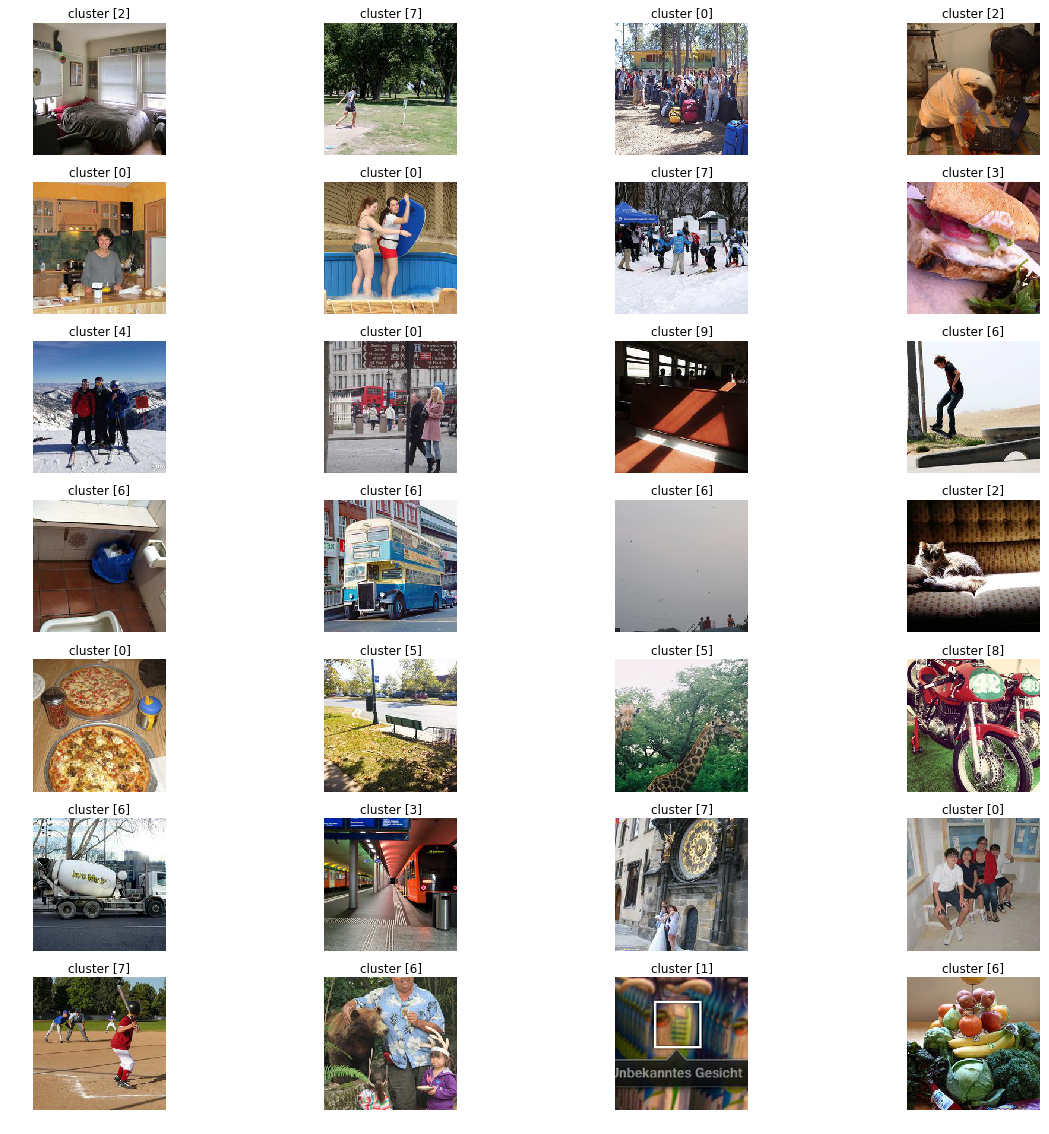

In [10]:
imgs = [plt.imread("/home/leo/Desktop/Tesi/images_for_clustering/"+i) for i in files]
'''
for cluster, img in zip(labels, imgs):
    plt.figure()
    plt.imshow(img)
    plt.title("Cluster %s" % cluster)
'''
import itertools
# Set up a grid of plots
fig = plt.figure(figsize=(20,20)) 
fig_dims = (7, 4)

positions = itertools.product(range(7), range(4))

i=0
for col, pos in zip(imgs, positions) :
    plt.subplot2grid(fig_dims, pos)
    plt.imshow(imgs[i])
    plt.title("cluster %s" % labels[i])
    plt.axis("off")
    i = i+1

## Let's see the top 5 prediction for some image

775 sandal 0.0024019394
807 sock 0.0031678732
617 knot 0.0057588248
601 hook, claw 0.019944347
328 starfish, sea star 0.8703469


(299, 299, 3)

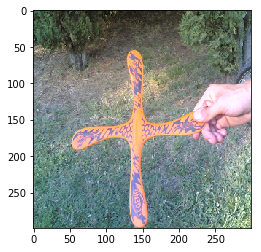

In [11]:
images = transform_img_fn(['boomerang.jpg'])
test_images = transform_img_fn(['cat.jpg', 'water_snake.jpg', 'cani.jpg', 'mare.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_fn(images)
for x in preds.argsort()[0][-5:]:
    print x, names[x], preds[0,x]
    
images[0].shape

In [12]:
top_pred = preds.argsort()[0][-5:][4]

In [13]:
image = images[0]

In [15]:
## Now let's get an explanation

sys.path.append('/home/leo/Desktop/Tesi/lime')
from lime import lime_image
import time

In [17]:
def gridSegmentation(parts, img):
    
    segments = np.zeros(img.shape[:2])
    segments_per_row = img.shape[:2][0] / parts
    
    i_segment_number = 1
    for i in range(0, img.shape[:2][0]):
        
        j_segment_number = i_segment_number - 1
        
        for j in range(0, img.shape[:2][1]):
            
            if (j % segments_per_row) == 0:
                j_segment_number = j_segment_number + 1
                
            segments[i,j] = j_segment_number
            
        if ((i+1) % segments_per_row) == 0:
            i_segment_number = j_segment_number + 1
        
    return segments.astype(int)

In [16]:
explainer = lime_image.LimeImagePatchworkExplainer(test_images)

In [34]:
from functools import partial
tmp = time.time()
# 'explainer' is an instance of LineImagePatchworkExplainer
explanation, samples = explainer.explain_instance(image, 
                                                  predict_fn, # this is the 'classifier_function'
                                                  top_labels=5, 
                                                  hide_color=0, 
                                                  num_samples=1000,
                                                  segmentation_fn=partial(gridSegmentation,5)
                                                  )
print time.time() - tmp

262.557471991


In [36]:
classic_explainer = lime_image.LimeImageExplainer()

In [41]:
from functools import partial
tmp = time.time()
# 'classic_explainer' is an instance of LineImageExplainer
classic_explanation = classic_explainer.explain_instance(image, 
                                                  predict_fn, # this is the 'classifier_function'
                                                  top_labels=5, 
                                                  hide_color=0, 
                                                  num_samples=1000,
                                                  segmentation_fn=partial(gridSegmentation,5)
                                                  )
print time.time() - tmp

262.882622957


In [42]:
from skimage.segmentation import mark_boundaries

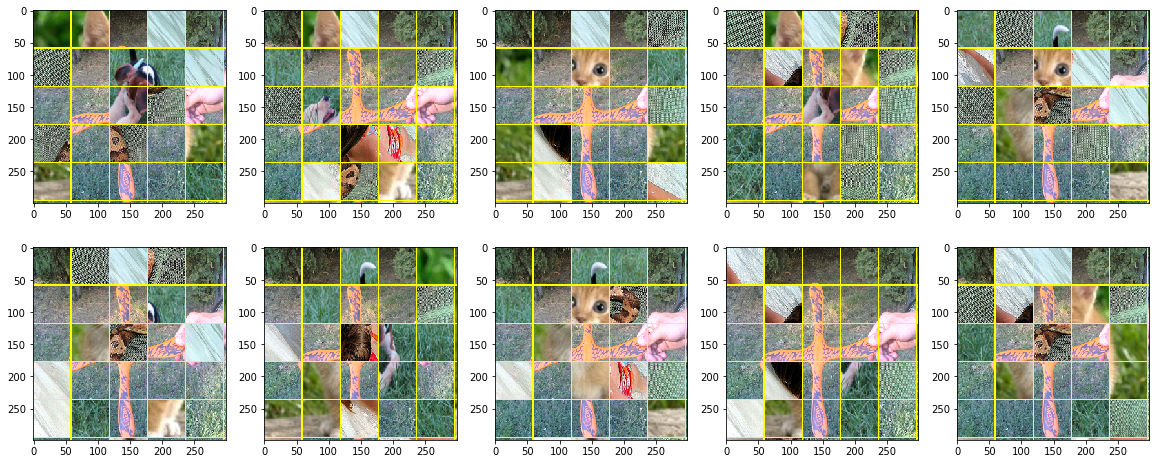

In [43]:
import itertools
# Set up a grid of plots
fig = plt.figure(figsize=(20,8)) 
fig_dims = (2, 5)

positions = itertools.product(range(2), range(5))

# plot bar charts
i=0
for col, pos in zip(samples, positions) :
    plt.subplot2grid(fig_dims, pos)
    plt.imshow(mark_boundaries(samples[i]/2+0.5,explanation.segments.astype(int)))
    i = i+1


In [1]:
copia = explanation.image.copy()
maschera = np.zeros(explanation.segments.shape, explanation.segments.dtype)

for feat in [x[0] for x in explanation.local_exp[top_pred]][:10]:
    copia[explanation.segments == feat] = 1
    maschera[explanation.segments == feat] = 1

#plt.imshow(mark_boundaries(copia/2+0.5, maschera))
copia[maschera] = 1

bool_mask = np.zeros(explanation.segments.shape).astype(bool)

copia2 = explanation.image.copy()
seg = np.unique(explanation.segments)
for s in np.unique(explanation.segments[0]):
    bool_mask[explanation.segments == s] = False

copia2[bool_mask] = 0.5
plt.imshow(mark_boundaries(copia2/2+0.5,explanation.segments))

print explanation.segments.shape, explanation.segments
print np.unique(explanation.segments[0])

# print sorted(explanation.local_exp[top_pred])

print explanation.score, explanation.local_pred

NameError: name 'explanation' is not defined

Image classifiers are a bit slow. Notice that an explanation in my macbookpro took 7.33 minutes

In [160]:
de = np.random.randint(0,2,15).reshape(3,5)

print de
for row in de:
    z = np.where(row==0)[0]
    print z

[[0 0 0 1 0]
 [0 1 0 1 1]
 [1 1 1 1 1]]
[0 1 2 4]
[0 2]
[]


### Now let's see the explanation for the top class

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

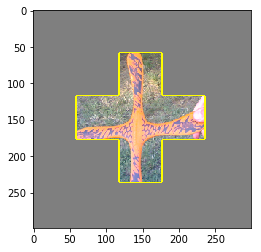

In [48]:
temp, mask = explanation.get_image_and_mask(top_pred, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

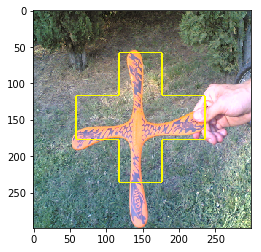

In [24]:
temp, mask = explanation.get_image_and_mask(top_pred, positive_only=True, num_features=5, hide_rest=False)
temp[mask]=1
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## Let's see all the positive and negative contributions

Text(0.5,1,'Lime# con superpixel spenti')

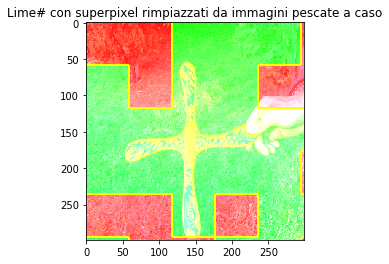

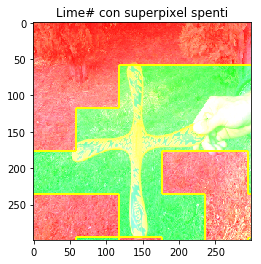

In [47]:
# Here we clearly see that, using a random image to replace the tiles
# of the original image in the neighborhood, the explanation makes
# less sense.

temp, mask = explanation.get_image_and_mask(top_pred, positive_only=False, 
                                            num_features=45, 
                                            hide_rest=False,
                                            min_weight=0.00)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("Lime# con superpixel rimpiazzati da immagini pescate a caso")
temp2,mask2 = classic_explanation.get_image_and_mask(top_pred, positive_only=False, 
                                            num_features=45, 
                                            hide_rest=False,
                                            min_weight=0.00)
plt.figure()
plt.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))
plt.title("Lime# con superpixel spenti")

### Or the pros and cons that have weight at least 0.1

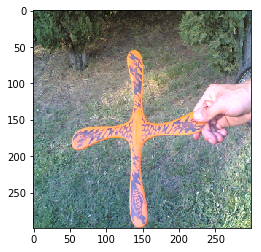

In [59]:
temp, mask = explanation.get_image_and_mask(top_pred, 
                                            positive_only=False, 
                                            num_features=1000, 
                                            hide_rest=False, 
                                            min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Let's see the explanation for Egyptian cat 

Most positive towards egyptian cat:

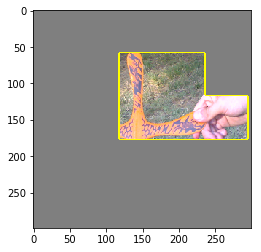

In [52]:
temp, mask = explanation.get_image_and_mask(601, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Pros and cons:

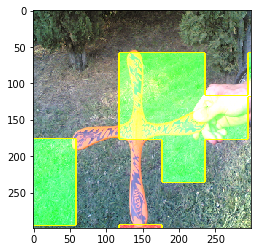

In [51]:
temp, mask = explanation.get_image_and_mask(601, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
